In [1]:
%matplotlib inline
import os
from subprocess import call

import xarray as xr
import numpy as np
import cftime
import dask

from scipy import signal

from itertools import product

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib as mpl
import  matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean

import geotools as gt
import plottools as pt
import project as P

USER = os.environ['USER']

In [2]:
xr_open_ds = {'chunks' : {'time':1},
              'decode_coords' : False,
              'decode_times' : False}
xr.set_options(enable_cftimeindex=True)

year_range = np.array((249,316))+1699
time = [cftime.DatetimeNoLeap(year, month, 1) for year, month in 
                  product(range(year_range[0], year_range[1]+1), range(1, 13))]
year = [y*1. for y in range(year_range[0],year_range[1]+1)]
ypm = np.array([31,28,31,30,31,30,31,31,30,31,30,31])/365
wgt = xr.DataArray(np.tile(ypm,int(np.diff(year_range)+1)),dims=('time'),coords={'time':time})

np.testing.assert_allclose(wgt.groupby('time.year').sum(),1.)

In [3]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster

dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})

# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)

/glade/work/mclong/miniconda3/envs/py3/lib/python3.6/site-packages/distributed/bokeh/core.py:55: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [4]:
Nnodes = 2
cluster.scale(9*Nnodes)

In [5]:
clobber = False

droot = '/glade/p_old/decpred/CESM-DPLE_POPCICEhindcast'
variables = ['PD','O2','PV','HMXL','HBLT','TEMP','SALT']

file_out = f'{P.dirt}/work.fosi_npac_ann_means.zarr'

if clobber:
    call(['rm','-fr',file_out])

if os.path.exists(file_out):
    ds = xr.open_zarr(file_out,decode_times=False,decode_coords=False)

else:
    dsm = xr.Dataset()
    for v in variables:
        dsm = xr.merge((dsm,xr.open_dataset(f'{droot}/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.{v}.024901-031612.nc',**xr_open_ds)))
    grid_vars = [v for v in dsm.variables if 'time' not in dsm[v].dims]
    dsm.time.values = time
    
    # subset to N Pac
    dsm = dsm.isel(nlat=slice(187,331),nlon=slice(137,276))
    
    # save attrs
    attrs = {v:dsm[v].attrs for v in dsm.variables}
    encoding = {v:dsm[v].encoding for v in dsm.variables}
    
    # groupby.sum() does not seem to handle missing values correctly: yields 0 not nan
    # the groupby.mean() does return nans, so create a mask of valid values for each variable
    valid = {v : dsm[v].groupby('time.year').mean(dim='time').notnull().rename({'year':'time'}) for v in variables}    
   
    # compute the annual means
    ds = (dsm.drop(grid_vars) * wgt).groupby('time.year').sum('time').rename({'year':'time'},inplace=True)
    
    # put the grid variables back
    ds = xr.merge((ds,dsm.drop([v for v in dsm.variables if v not in grid_vars]))) 
    
    # apply the valid-values mask
    for v in variables:
        ds[v] = ds[v].where(valid[v])

    # put the attributes back
    for v in ds.variables:
        ds[v].attrs = attrs[v]

    # put the encoding back
    for v in ds.variables:
        ds[v].encoding = encoding[v]
        
    print(f'writing {file_out}')
    ds.to_zarr(file_out)

ds.PD.values = (ds.PD-1.)*1000.

In [6]:
dsr = P.regional_mean(ds)
dsr = dsr.compute()

In [7]:
dsrm = dsr.sel(time=P.year_range_clim).mean('time')
dsra = dsr - dsrm

In [37]:
droot = '/glade/p/cgd/oce/projects/DPLE_O2/wod2013'
extraction = 'global_req_temp_salt_o2'
max_depth = 2000.
obs = xr.open_dataset(os.path.join(droot,extraction+'.gridded.z.anom_wrt_woa.ann.nc'),decode_times=False)

#-- add dz which was not created properly
from wod_info import standard_z,standard_z_depth_bounds
standard_z_selection = (standard_z<=max_depth)
depth_coord = standard_z[standard_z_selection]
dz = np.diff(standard_z_depth_bounds[standard_z_selection,:],axis=1)[:,0]
obs.dz.values = dz

#obs = obs.isel(time=np.where((1958<=ds.year)&(ds.year<=2014))[0])

#-- select the thermocline
obs = obs.sel(depth=slice(200,600))

#-- select CalCOFI
obsr = obs.copy()
obsr.lon.values = np.where(obsr.lon<0.,obsr.lon+360.,obsr.lon)
obsr = obsr.roll(lon=180).sel(lat=slice(25,38),lon=slice(360-126,360-115))
vol = obsr.oxygen.notnull() * obsr.dz * obsr.area
obs_vol_wgt = vol / vol.sum(dim=['lon','lat','depth'])
obs_o2 = (obsr.oxygen * obs_vol_wgt).sum(dim=['lon','lat','depth'])

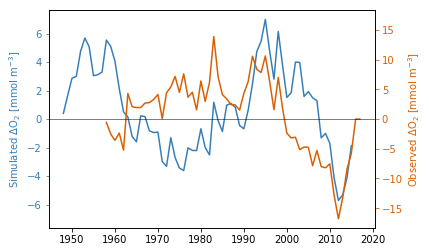

In [25]:
fig = plt.figure()
axL = fig.add_subplot(111)
plt.plot(dsra.time,dsra.O2.sel(z_t=slice(200e2,600e2)).mean('z_t'),color='#377eb8')
axL.set_ylabel('Simulated $\Delta$O$_2$ [mmol m$^{-3}$]', color='#377eb8')
axL.tick_params('y', colors='#377eb8')
ylm = np.fabs(axL.get_ylim()).max()
axL.set_ylim((-ylm,ylm))

axR = axL.twinx()
plt.plot(obs.year,obs_o2,color='#d95f02')
axR.set_ylabel('Observed $\Delta$O$_2$ [mmol m$^{-3}$]', color='#d95f02')
axR.tick_params('y', colors='#d95f02')
ylm = np.fabs(axR.get_ylim()).max()
axR.set_ylim((-ylm,ylm))

axR.axhline(0.,linewidth=0.5,color='k')

plt.subplots_adjust(right=0.88)
plt.savefig(f'{P.dirf}/CalCOFI-fosi-skill-wrt-wod2013.pdf')

In [38]:
cnt = obs.oxygen_cnt.sel(depth=200)
years_sampled_fraction = cnt.where(cnt<=0).fillna(1).sum(dim='time') / len(obs.year)
years_sampled_fraction.name = 'Fraction of years sampled'

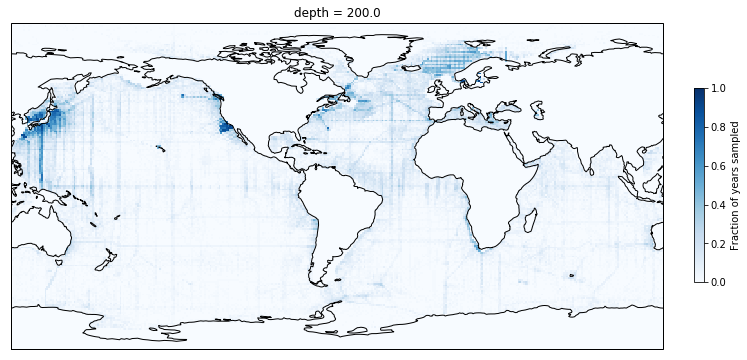

In [61]:
fig = plt.figure(figsize=(15,6))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=300))

years_sampled_fraction.plot.pcolormesh(ax=ax,vmax=1,transform=ccrs.PlateCarree(),cmap='Blues')
ax.coastlines()

cb = fig.get_children()[-1]
p = cb.get_position()
cb.set_position([p.x0-0.01,0.28,0.04,0.45])
plt.savefig(f'{P.dirf}/wod2013-fraction-years-sampled.pdf',bbox_inches='tight')